# Training our Fruit Classifer
### Experimenting with Callbacks
- Let's create our data generators

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 131 
img_rows, img_cols = 32, 32
batch_size = 64

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C:/datasets/fruits-360/Training'
validation_data_dir = 'C:/datasets/fruits-360/Test'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Using TensorFlow backend.


Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


### Let's define our model

In [3]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [4]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("fruits_fresh_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 67692 
nb_validation_samples = 22688 
epochs = 1

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/1
1057/1057 [==============================] - 172s 163ms/step - loss: 2.4164 - accuracy: 0.3345 - val_loss: 2.4746 - val_accuracy: 0.7614

Epoch 00001: val_loss improved from inf to 2.47461, saving model to fruits_fresh_cnn_1.h5


### Displaying our Confusion Matrix

In [10]:
class_labels = validation_generator.class_indices

target_names = list(class_labels)

print(target_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
class_labels = validation_generator.class_indices
target_names = list(class_labels)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[127   0   0 ...   0   0   0]
 [  0  61   0 ...   0   0   0]
 [  0   0  75 ...   0   0   0]
 ...
 [  0   0   0 ...  90   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0  26]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.46      0.77      0.57       164
 Apple Crimson Snow       0.62      0.41      0.50       148
     Apple Golden 1       0.65      0.47      0.54       160
     Apple Golden 2       0.33      0.95      0.49       164
     Apple Golden 3       0.33      1.00      0.50       161
 Apple Granny Smith       0.00      0.00      0.00       164
    Apple Pink Lady       0.86      0.72      0.78       152
        Apple Red 1       0.66      0.32      0.43       164
        Apple Red 2       0.45      0.96      0.61       164
        Apple Red 3       0.74      1.00      0.85       144
Apple Red Delicious       0.98      1.00      0.99       166
 Apple Red Yellow 1       1.00      

C:\Users\Siyam\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


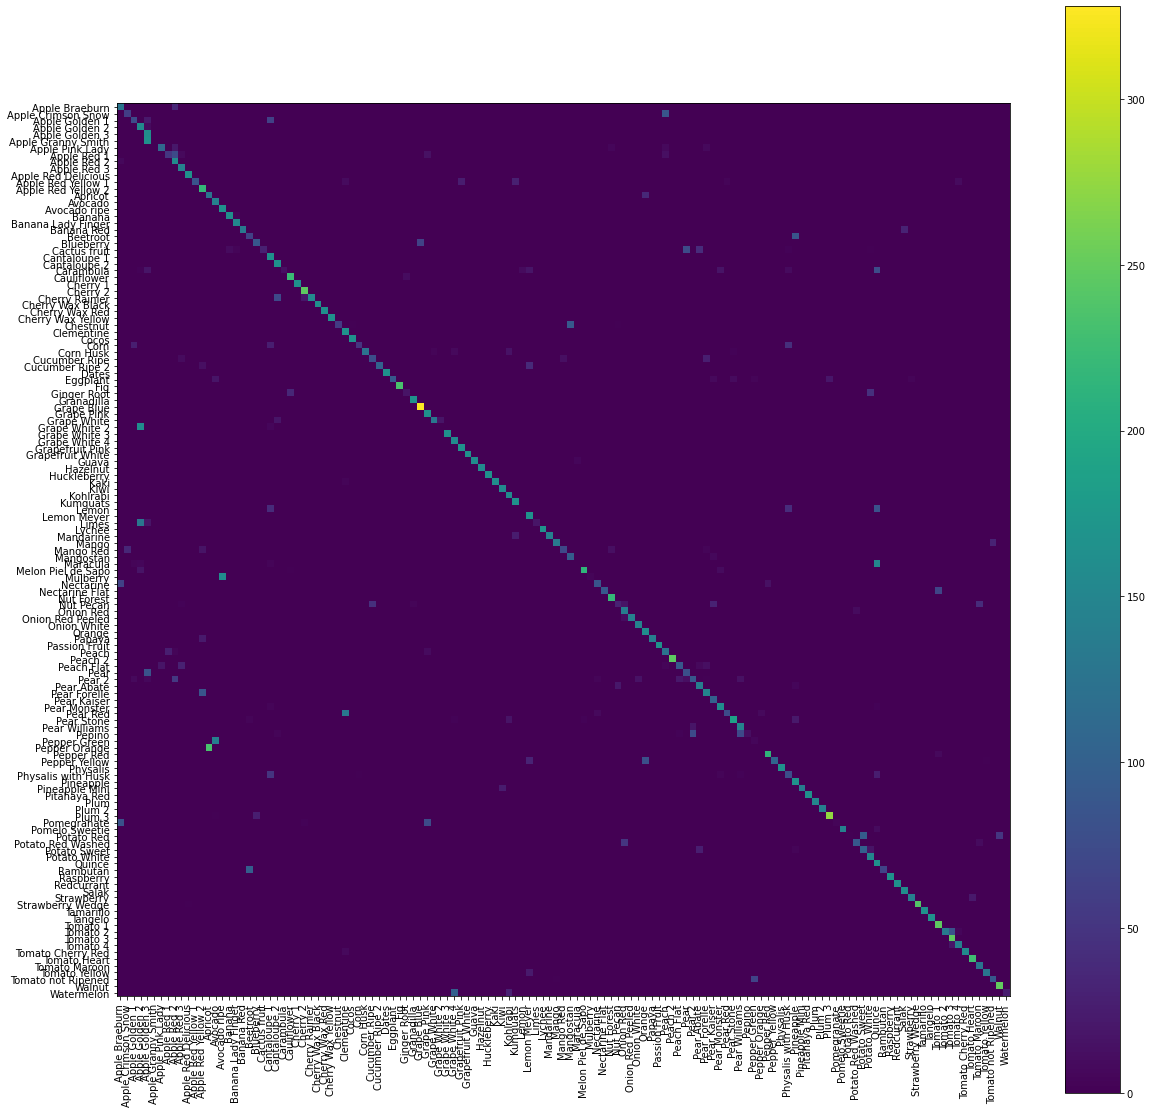

In [15]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 67692
nb_validation_samples = 22688

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Testing our fruit classifier

In [17]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list( os.listdir(path))                     # List of all flowers within test dir (OF 131 classes)
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]                #A random folder EX: Potato Red Washed
    file_path = path + path_class                         # file_path = C:/datasets/fruits-360/Test/Potato Red Washed
    file_names = [f for f in listdir(file_path)]         # All images within FOLDER Potato Red Washed 
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]           #A random Image from FOLDER Potato Red Washed(C:/datasets/fruits-360/Test/Potato Red Washed/r2_160_100.jpg)
    final_path = file_path + "/" + image_name   #C:/datasets/fruits-360/Test/Potato Red Washed "/" r2_160_100.jpg
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = 'C:/datasets/fruits-360/Test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [25]:
path = 'C:/datasets/fruits-360/Test/' 
list( os.listdir(path))

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [26]:
file_path = "C:/datasets/fruits-360/Test/Potato Red Washed"
file_names = [f for f in listdir(file_path)]
file_names

['30_100.jpg',
 '31_100.jpg',
 '33_100.jpg',
 '35_100.jpg',
 '36_100.jpg',
 '37_100.jpg',
 '38_100.jpg',
 '39_100.jpg',
 '40_100.jpg',
 '41_100.jpg',
 '42_100.jpg',
 '43_100.jpg',
 '44_100.jpg',
 '45_100.jpg',
 '46_100.jpg',
 '47_100.jpg',
 '48_100.jpg',
 '49_100.jpg',
 '50_100.jpg',
 '51_100.jpg',
 '52_100.jpg',
 '53_100.jpg',
 '54_100.jpg',
 '55_100.jpg',
 '56_100.jpg',
 '57_100.jpg',
 '58_100.jpg',
 '59_100.jpg',
 '60_100.jpg',
 '61_100.jpg',
 '62_100.jpg',
 '63_100.jpg',
 '64_100.jpg',
 '65_100.jpg',
 '66_100.jpg',
 '67_100.jpg',
 '68_100.jpg',
 '69_100.jpg',
 '70_100.jpg',
 '71_100.jpg',
 '72_100.jpg',
 '73_100.jpg',
 '74_100.jpg',
 '75_100.jpg',
 '76_100.jpg',
 '77_100.jpg',
 '78_100.jpg',
 '79_100.jpg',
 '80_100.jpg',
 '81_100.jpg',
 'r2_139_100.jpg',
 'r2_140_100.jpg',
 'r2_141_100.jpg',
 'r2_142_100.jpg',
 'r2_143_100.jpg',
 'r2_144_100.jpg',
 'r2_145_100.jpg',
 'r2_146_100.jpg',
 'r2_147_100.jpg',
 'r2_148_100.jpg',
 'r2_149_100.jpg',
 'r2_150_100.jpg',
 'r2_151_100.jpg',
 'r